# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
# importing the files
!gdown --id "1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL"
!unzip /content/Project_data.zip
!pip install scipy==1.1.0

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00007.png  
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00009.png  
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00011.png  
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00013.png  
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00015.png  
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00017.png  
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00019.png  
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00021.png  
 extracting: Project_data/train/WIN_20180926_17_35_12

In [2]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
project_folder='/content/Project_data'

In [6]:
train_doc = np.random.permutation(open(project_folder+'/train.csv').readlines())
val_doc = np.random.permutation(open(project_folder+'/val.csv').readlines())
batch_size = 10 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
x = 100
y = 100
image_index = np.arange(1,30,2) # Take alternative images
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # Number of Images need to consider 
    img_idx = image_index #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = (len(folder_list))//batch_size# calculate the number of batches
        pending_Data = (len(folder_list)) - (num_batches * batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),x,y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #image = imread(source_path+'/'+ t[folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(x,y,3)) # As 1 Image size is 360*360 and another is 120*160. Hence both converted to 100*100
                    image_0 = image[:,:, 0]/255
                    image_1 = image[:,:, 1]/255
                    image_2 = image[:,:, 2]/255
                    batch_data[folder,idx,:,:,0] = image_0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_1 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_2 #normalise and feed in the image
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        # write the code for the remaining data points which are left after full batches
        if(pending_Data > 0):
            batch_data = np.zeros((batch_size,len(img_idx),x,y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5))
            for folder in range(pending_Data):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches * batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches * batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(x,y,3)) # As 1 Image size is 360*360 and another is 120*160. Hence both converted to 100*100
                    image_0 = image[:,:, 0]/255
                    image_1 = image[:,:, 1]/255
                    image_2 = image[:,:, 2]/255
                    batch_data[folder,idx,:,:,0] = image_0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_1 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_2 #normalise and feed in the image
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/Project_data/train'
val_path = '/content/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs =10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2

#write your model here

num_classes = 5
#Shape to the Conv3D is initialized here
input_shape = np.zeros((batch_size,len(image_index),x,y,3))

In [10]:
from keras import optimizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv3D, Conv2D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import ResNet50,vgg16
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, Input,Multiply, Masking, Reshape, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, GlobalAveragePooling2D

def conv3D(useMoresLayer = False):
    # #write your model here
    model = Sequential()
    model.add(Conv3D(64, (3, 3, 3), padding='same', 
                    input_shape=input_shape.shape[1:]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv3D(64, (3, 3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(3, 3, 3)))
    model.add(Dropout(0.30))
    
    if useMoresLayer:
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Conv3D(64, (2, 2, 2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Conv3D(128, (2, 2, 2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    return model

In [11]:
def conv2d_With_LSTM(useMoresLayer = False):
    #write your model here
    model = Sequential()

    model.add(TimeDistributed(Conv2D(32, (3, 3), strides=(2, 2),
                activation='relu', padding='same'), input_shape=input_shape.shape[1:]))
    model.add(TimeDistributed(Conv2D(32, (3,3),
                kernel_initializer="he_normal", activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
    model.add(TimeDistributed(Dropout(0.20)))

    model.add(TimeDistributed(Conv2D(64, (3,3),
                padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(64, (3,3),
                padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
    model.add(TimeDistributed(Dropout(0.20)))
    if useMoresLayer:
        model.add(TimeDistributed(Conv2D(128, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(128, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        model.add(TimeDistributed(Dropout(0.25)))

        model.add(TimeDistributed(Conv2D(256, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(256, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        model.add(TimeDistributed(Dropout(0.25)))

        model.add(TimeDistributed(Conv2D(512, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(512, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    #model.add(Dropout(0.5))
    model.add(LSTM(256, return_sequences=False, dropout=0.20))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [12]:
def Conv2d_With_GRU(useMoresLayer = False):
    #write your model here
    model = Sequential()

    model.add(TimeDistributed(Conv2D(32, (3, 3), strides=(2, 2),
                activation='relu', padding='same'), input_shape=input_shape.shape[1:]))
    model.add(TimeDistributed(Conv2D(32, (3,3),
                kernel_initializer="he_normal", activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
    model.add(TimeDistributed(Dropout(0.20)))

    model.add(TimeDistributed(Conv2D(64, (3,3),
                padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(64, (3,3),
                padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
    model.add(TimeDistributed(Dropout(0.20)))
    if useMoresLayer:
        model.add(TimeDistributed(Conv2D(128, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(128, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        model.add(TimeDistributed(Dropout(0.25)))

        model.add(TimeDistributed(Conv2D(256, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(256, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        model.add(TimeDistributed(Dropout(0.25)))

        model.add(TimeDistributed(Conv2D(512, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(512, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    #model.add(Dropout(0.5))
    model.add(GRU(256, return_sequences=False, dropout=0.20))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [13]:

def Resnet_CNN_LSTM():
    resnet = ResNet50(include_top=False, weights='imagenet', pooling = 'avg')
    input_layer = Input(shape=input_shape.shape[1:])
    curr_layer = TimeDistributed(resnet)(input_layer)
    #curr_layer = Dropout(0.25)(curr_layer)
    curr_layer = Reshape(target_shape=(input_shape.shape[1:][0], 2048))(curr_layer)
    lstm_out = LSTM(256, dropout=0.25)(curr_layer)
    output = Dense(num_classes, activation='softmax')(lstm_out)
    model = Model([input_layer], output)
    return model

def Resnet_CNN_GRU():
    resnet = ResNet50(include_top=False, weights='imagenet', pooling = 'avg')
    input_layer = Input(shape=input_shape.shape[1:])
    curr_layer = TimeDistributed(resnet)(input_layer)
    #curr_layer = Dropout(0.25)(curr_layer)
    curr_layer = Reshape(target_shape=(input_shape.shape[1:][0], 2048))(curr_layer)
    gru_out = GRU(256, dropout=0.25)(curr_layer)
    output = Dense(num_classes, activation='softmax')(gru_out)
    model = Model([input_layer], output)
    return model

def Vgg_CNN_LSTM():
    vggNet = vgg16.VGG16(weights='imagenet', include_top=False, pooling='avg')
    input_layer = Input(shape=input_shape.shape[1:])
    curr_layer = TimeDistributed(vggNet)(input_layer)
    #curr_layer = Dropout(0.25)(curr_layer)
    curr_layer = Reshape(target_shape=(input_shape.shape[1:][0], 512))(curr_layer)
    gru_out = LSTM(256, dropout=0.25)(curr_layer)
    output = Dense(num_classes, activation='softmax')(gru_out)
    model = Model([input_layer], output)
    return model


"""
    modelName:
                1. Resnet_CNN_LSTM
                2. Resnet_CNN_GRU
                3. Conv2d_With_GRU
                4. conv2d_With_LSTM
                5. conv3D
                6. Vgg_CNN_LSTM
"""

def modelExecution(modelName = 'Resnet_CNN_LSTM', extendLayers=False):
    if modelName == 'Resnet_CNN_LSTM':
        model = Resnet_CNN_LSTM()
    elif modelName == 'Resnet_CNN_GRU':
        model = Resnet_CNN_GRU()
    elif modelName == 'Cov2d_With_GRU':
        model = Conv2d_With_GRU(extendLayers)
    elif modelName == 'conv2d_With_LSTM':
        model = conv2d_With_LSTM(extendLayers)
    elif modelName == 'Vgg_CNN_LSTM':
        model = Vgg_CNN_LSTM()
    else:
        model = conv3D(extendLayers)
    return model, modelName

In [14]:
model, modelName = modelExecution(modelName = 'Resnet_CNN_LSTM')

94773248/94765736 [==============================] - 1s 0us/step


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [14]:
optimiser = 'SGD' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 15, 100, 100, 3)] 0         
_________________________________________________________________
time_distributed (TimeDistri (None, 15, 2048)          23587712  
_________________________________________________________________
reshape (Reshape)            (None, 15, 2048)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               2360320   
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 25,949,317
Trainable params: 25,896,197
Non-trainable params: 53,120
_________________________________________________________________
None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [15]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [16]:
import keras
class DecayLR(keras.callbacks.Callback):
    def __init__(self, base_lr=0.1, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [ ]:
model_name = modelName + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = DecayLR() # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model_result=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/10
21/34 [=================>............] - ETA: 8:14 - loss: 1.3278 - categorical_accuracy: 0.4595

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 1310s 39s/step - loss: 1.1350 - categorical_accuracy: 0.5235 - val_loss: 3.2576 - val_categorical_accuracy: 0.2200

Epoch 00001: saving model to Resnet_CNN_LSTM_2021-03-2607_55_48.701574/model-00001-1.13497-0.52353-3.25758-0.22000.h5
Epoch 2/10
34/34 [==============================] - 1330s 39s/step - loss: 0.6027 - categorical_accuracy: 0.7588 - val_loss: 2.8727 - val_categorical_accuracy: 0.2000

Epoch 00002: saving model to Resnet_CNN_LSTM_2021-03-2607_55_48.701574/model-00002-0.60274-0.75882-2.87275-0.20000.h5
Epoch 3/10
34/34 [==============================] - 1320s 39s/step - loss: 0.2730 - categorical_accuracy: 0.8853 - val_loss: 2.0536 - val_categorical_accuracy: 0.2900

Epoch 00003: saving model to Resnet_CNN_LSTM_2021-03-2607_55_48.701574/model-00003-0.27300-0.88529-2.05356-0.29000.h5
Epoch 4/10
34/34 [==============================] - 1298s 38s/step - loss: 0.0934 - categorical_accuracy: 0.9529 - val_loss: 2.9834 - val_categorical_acc

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


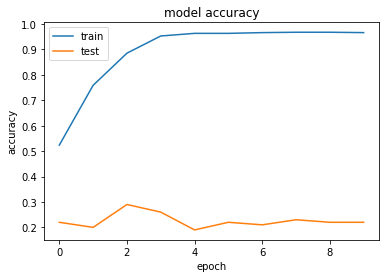

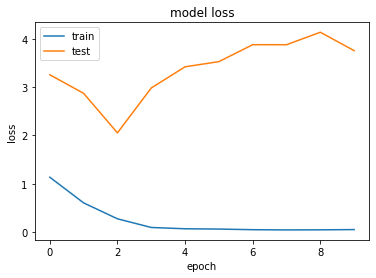

In [ ]:
import matplotlib.pyplot as plt
modelExec_History=model_result
print(modelExec_History.history.keys())
# summarize history for accuracy
plt.plot(modelExec_History.history['categorical_accuracy'])
plt.plot(modelExec_History.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(modelExec_History.history['loss'])
plt.plot(modelExec_History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model, modelName = modelExecution(modelName = 'Resnet_CNN_GRU')
optimiser = 'SGD' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 15, 40, 40, 3)]   0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 2048)          23587712  
_________________________________________________________________
reshape_2 (Reshape)          (None, 15, 2048)          0         
_________________________________________________________________
gru (GRU)                    (None, 256)               1771008   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 25,360,005
Trainable params: 25,306,885
Non-trainable params: 53,120
_________________________________________________________________
None


In [ ]:
model_result=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/10
20/34 [================>.............] - ETA: 9:22 - loss: 2.2030 - categorical_accuracy: 0.2654 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 1380s 40s/step - loss: 1.9760 - categorical_accuracy: 0.3015 - val_loss: 2.0074 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to Resnet_CNN_LSTM_2021-03-2607_55_48.701574/model-00001-1.60671-0.36471-2.00740-0.21000.h5
Epoch 2/10
34/34 [==============================] - 1323s 39s/step - loss: 1.2362 - categorical_accuracy: 0.5032 - val_loss: 1.7104 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to Resnet_CNN_LSTM_2021-03-2607_55_48.701574/model-00002-1.06364-0.56324-1.71040-0.21000.h5
Epoch 3/10
34/34 [==============================] - 1308s 39s/step - loss: 0.6564 - categorical_accuracy: 0.7187 - val_loss: 1.6983 - val_categorical_accuracy: 0.1900

Epoch 00003: saving model to Resnet_CNN_LSTM_2021-03-2607_55_48.701574/model-00003-0.58814-0.74118-1.69830-0.19000.h5
Epoch 4/10
34/34 [==============================] - 1285s 38s/step - loss: 0.2838 - categorical_accuracy: 0.9028 - val_loss: 1.6423 - val_categorical_acc

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


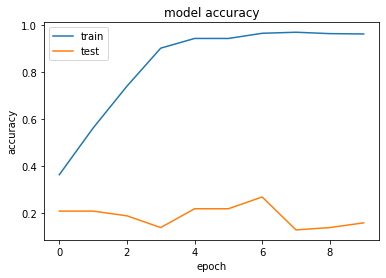

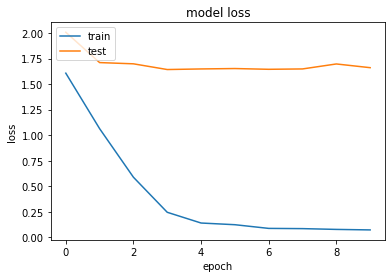

In [ ]:
import matplotlib.pyplot as plt
modelExec_History=model_result
print(modelExec_History.history.keys())
# summarize history for accuracy
plt.plot(modelExec_History.history['categorical_accuracy'])
plt.plot(modelExec_History.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(modelExec_History.history['loss'])
plt.plot(modelExec_History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
 #define plot function
 import matplotlib.pyplot as plt
 def plotSummary(modelExec_History):
   modelExec_History=model_result
   print(modelExec_History.history.keys())
   # summarize history for accuracy
   plt.plot(modelExec_History.history['categorical_accuracy'])
   plt.plot(modelExec_History.history['val_categorical_accuracy'])
   plt.title('model accuracy')
   plt.ylabel('accuracy')
   plt.xlabel('epoch')
   plt.legend(['train', 'test'], loc='upper left')
   plt.show()
   # summarize history for loss
   plt.plot(modelExec_History.history['loss'])
   plt.plot(modelExec_History.history['val_loss'])
   plt.title('model loss')
   plt.ylabel('loss')
   plt.xlabel('epoch')
   plt.legend(['train', 'test'], loc='upper left')
   plt.show()


In [18]:
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

In [ ]:
batch_size = 15
num_epochs = 30
x = 120
y = 120
image_index = np.arange(1,30,2) # Take alternative images




num_classes = 5
input_shape = np.zeros((batch_size,len(image_index),x,y,3))


def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # Number of Images need to consider 
    img_idx = image_index #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = (len(folder_list))//batch_size# calculate the number of batches
        pending_Data = (len(folder_list)) - (num_batches * batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),x,y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #image = imread(source_path+'/'+ t[folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(x,y,3)) # As 1 Image size is 360*360 and another is 120*160. Hence both converted to 100*100

                    image_0 = image[:,:, 0]/255
                    image_1 = image[:,:, 1]/255
                    image_2 = image[:,:, 2]/255
                    batch_data[folder,idx,:,:,0] = image_0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_1 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_2 #normalise and feed in the image
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        # write the code for the remaining data points which are left after full batches
        if(pending_Data > 0):
            batch_data = np.zeros((batch_size,len(img_idx),x,y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5))
            for folder in range(pending_Data):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches * batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches * batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(x,y,3)) # As 1 Image size is 360*360 and another is 120*160. Hence both converted to 100*100

                    image_0 = image[:,:, 0]/255
                    image_1 = image[:,:, 1]/255
                    image_2 = image[:,:, 2]/255
                    batch_data[folder,idx,:,:,0] = image_0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_1 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_2 #normalise and feed in the image
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do







model, modelName = modelExecution(modelName = 'conv2d_With_LSTM', extendLayers=True)
optimiser = 'SGD' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
print (model.summary())

model_name = modelName + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = DecayLR() # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
model_result=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_108 (TimeDi (None, 15, 60, 60, 32)    896       
_________________________________________________________________
time_distributed_109 (TimeDi (None, 15, 58, 58, 32)    9248      
_________________________________________________________________
time_distributed_110 (TimeDi (None, 15, 58, 58, 32)    128       
_________________________________________________________________
time_distributed_111 (TimeDi (None, 15, 29, 29, 32)    0         
_________________________________________________________________
time_distributed_112 (TimeDi (None, 15, 29, 29, 32)    0         
_________________________________________________________________
time_distributed_113 (TimeDi (None, 15, 29, 29, 64)    18496     
_________________________________________________________________
time_distributed_114 (TimeDi (None, 15, 29, 29, 64)   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/30
43/45 [===========================>..] - ETA: 20s - loss: 1.7682 - categorical_accuracy: 0.2841

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


45/45 [==============================] - 487s 11s/step - loss: 1.7567 - categorical_accuracy: 0.2866 - val_loss: 1.6899 - val_categorical_accuracy: 0.1810

Epoch 00001: saving model to conv2d_With_LSTM_2021-03-2708_37_01.771595/model-00001-1.58381-0.32000-1.68990-0.18095.h5
Epoch 2/30
45/45 [==============================] - 468s 10s/step - loss: 1.3879 - categorical_accuracy: 0.4085 - val_loss: 2.0538 - val_categorical_accuracy: 0.2095

Epoch 00002: saving model to conv2d_With_LSTM_2021-03-2708_37_01.771595/model-00002-1.30758-0.41630-2.05382-0.20952.h5
Epoch 3/30
45/45 [==============================] - 474s 11s/step - loss: 1.0956 - categorical_accuracy: 0.5460 - val_loss: 1.6931 - val_categorical_accuracy: 0.2476

Epoch 00003: saving model to conv2d_With_LSTM_2021-03-2708_37_01.771595/model-00003-1.08116-0.53185-1.69310-0.24762.h5
Epoch 4/30
45/45 [==============================] - 475s 11s/step - loss: 0.9425 - categorical_accuracy: 0.5998 - val_loss: 1.6100 - val_categorical_accu

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


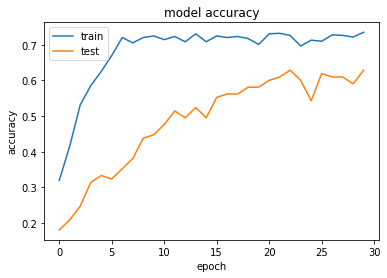

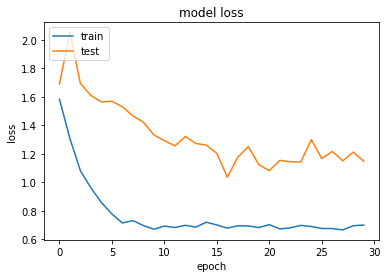

In [ ]:
plotSummary(model_result)

In [ ]:
from keras.optimizers import Adam
batch_size = 12
num_epochs = 50
x = 100
y = 100
image_index = np.arange(1,30,2) # Take alternative images




num_classes = 5
input_shape = np.zeros((batch_size,len(image_index),x,y,3))


def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # Number of Images need to consider 
    img_idx = image_index #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = (len(folder_list))//batch_size# calculate the number of batches
        pending_Data = (len(folder_list)) - (num_batches * batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),x,y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #image = imread(source_path+'/'+ t[folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Cropping non symmetric frames
                    if image.shape[0] != image.shape[1]:
                      image=image[0:120,20:140]

                    image = imresize(image,(x,y,3)) # As 1 Image size is 360*360 and another is 120*160. Hence both converted to 100*100

                    image_0 = image[:,:, 0]/255
                    image_1 = image[:,:, 1]/255
                    image_2 = image[:,:, 2]/255
                    batch_data[folder,idx,:,:,0] = image_0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_1 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_2 #normalise and feed in the image
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        # write the code for the remaining data points which are left after full batches
        if(pending_Data > 0):
            batch_data = np.zeros((batch_size,len(img_idx),x,y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5))
            for folder in range(pending_Data):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches * batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches * batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Cropping non symmetric frames
                    if image.shape[0] != image.shape[1]:
                      image=image[0:120,20:140]

                    image = imresize(image,(x,y,3)) # As 1 Image size is 360*360 and another is 120*160. Hence both converted to 100*100

                    image_0 = image[:,:, 0]/255
                    image_1 = image[:,:, 1]/255
                    image_2 = image[:,:, 2]/255
                    batch_data[folder,idx,:,:,0] = image_0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_1 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_2 #normalise and feed in the image
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do







model, modelName = modelExecution(modelName = 'Cov2d_With_GRU', extendLayers=True)
optimiser = Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
print (model.summary())

model_name = modelName + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = DecayLR() # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
model_result=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 50, 50, 32)    896       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 48, 48, 32)    9248      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 48, 48, 32)    128       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 24, 24, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 24, 24, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 24, 24, 64)    18496     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 24, 24, 64)    3

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/50
54/56 [===========================>..] - ETA: 12s - loss: 4.5926 - categorical_accuracy: 0.2127

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


56/56 [==============================] - 380s 7s/step - loss: 4.5504 - categorical_accuracy: 0.2130 - val_loss: 7.1071 - val_categorical_accuracy: 0.2222

Epoch 00001: saving model to Cov2d_With_GRU_2021-03-2803_16_53.535989/model-00001-3.76923-0.21875-7.10715-0.22222.h5
Epoch 2/50
56/56 [==============================] - 368s 7s/step - loss: 3.4161 - categorical_accuracy: 0.2467 - val_loss: 4.9336 - val_categorical_accuracy: 0.1944

Epoch 00002: saving model to Cov2d_With_GRU_2021-03-2803_16_53.535989/model-00002-3.42151-0.26488-4.93364-0.19444.h5
Epoch 3/50
56/56 [==============================] - 368s 7s/step - loss: 2.8040 - categorical_accuracy: 0.2486 - val_loss: 1.9900 - val_categorical_accuracy: 0.2222

Epoch 00003: saving model to Cov2d_With_GRU_2021-03-2803_16_53.535989/model-00003-2.46556-0.22917-1.98999-0.22222.h5
Epoch 4/50
56/56 [==============================] - 372s 7s/step - loss: 2.2594 - categorical_accuracy: 0.2139 - val_loss: 2.1255 - val_categorical_accuracy: 0.26

In [19]:
batch_size = 15
num_epochs = 10
x = 100
y = 100
image_index = np.arange(1,30,2) # Take alternative images




num_classes = 5
input_shape = np.zeros((batch_size,len(image_index),x,y,3))
model, modelName = modelExecution(modelName = 'conv3d', extendLayers=False)
optimiser = 'SGD' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
print (model.summary())

model_name = modelName + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = DecayLR() # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
model_result=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 100, 100, 64)  5248      
_________________________________________________________________
activation (Activation)      (None, 15, 100, 100, 64)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 100, 100, 64)  256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 13, 98, 98, 64)    110656    
_________________________________________________________________
activation_1 (Activation)    (None, 13, 98, 98, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 98, 98, 64)    256       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 4, 32, 32, 64)     0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/10
43/45 [===========================>..] - ETA: 1s - loss: nan - categorical_accuracy: 0.1695

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


45/45 [==============================] - 85s 1s/step - loss: nan - categorical_accuracy: 0.1718 - val_loss: nan - val_categorical_accuracy: 0.2286

Epoch 00001: saving model to conv3d_2021-03-2806_41_45.931307/model-00001-nan-0.20889-nan-0.22857.h5
Epoch 2/10
45/45 [==============================] - 49s 1s/step - loss: nan - categorical_accuracy: 0.1993 - val_loss: nan - val_categorical_accuracy: 0.2381

Epoch 00002: saving model to conv3d_2021-03-2806_41_45.931307/model-00002-nan-0.21926-nan-0.23810.h5
Epoch 3/10
45/45 [==============================] - 49s 1s/step - loss: nan - categorical_accuracy: 0.2048 - val_loss: nan - val_categorical_accuracy: 0.1905

Epoch 00003: saving model to conv3d_2021-03-2806_41_45.931307/model-00003-nan-0.21926-nan-0.19048.h5
Epoch 4/10
45/45 [==============================] - 48s 1s/step - loss: nan - categorical_accuracy: 0.1970 - val_loss: nan - val_categorical_accuracy: 0.2571

Epoch 00004: saving model to conv3d_2021-03-2806_41_45.931307/model-0000

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


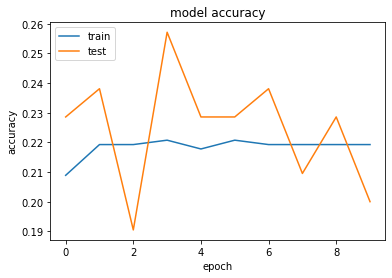

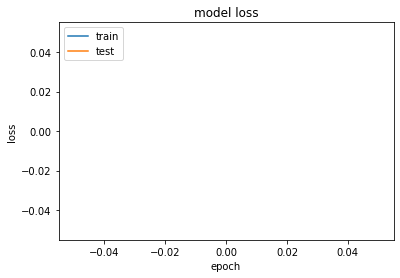

In [21]:
plotSummary(model_result)

In [22]:
batch_size = 15
num_epochs = 60
x = 120
y = 120
image_index = np.arange(1,30,2) # Take alternative images




num_classes = 5
input_shape = np.zeros((batch_size,len(image_index),x,y,3))


def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # Number of Images need to consider 
    img_idx = image_index #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = (len(folder_list))//batch_size# calculate the number of batches
        pending_Data = (len(folder_list)) - (num_batches * batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),x,y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #image = imread(source_path+'/'+ t[folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(x,y,3)) # As 1 Image size is 360*360 and another is 120*160. Hence both converted to 100*100

                    image_0 = image[:,:, 0]/255
                    image_1 = image[:,:, 1]/255
                    image_2 = image[:,:, 2]/255
                    batch_data[folder,idx,:,:,0] = image_0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_1 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_2 #normalise and feed in the image
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        # write the code for the remaining data points which are left after full batches
        if(pending_Data > 0):
            batch_data = np.zeros((batch_size,len(img_idx),x,y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5))
            for folder in range(pending_Data):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches * batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches * batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(x,y,3)) # As 1 Image size is 360*360 and another is 120*160. Hence both converted to 100*100

                    image_0 = image[:,:, 0]/255
                    image_1 = image[:,:, 1]/255
                    image_2 = image[:,:, 2]/255
                    batch_data[folder,idx,:,:,0] = image_0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_1 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_2 #normalise and feed in the image
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do







model, modelName = modelExecution(modelName = 'conv2d_With_LSTM', extendLayers=True)
optimiser = 'SGD' #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
print (model.summary())

model_name = modelName + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = DecayLR() # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
model_result=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 60, 60, 32)    896       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 58, 58, 32)    9248      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 58, 58, 32)    128       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 29, 29, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 29, 29, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 29, 29, 64)    18496     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 15, 29, 29, 64)   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/60
44/45 [============================>.] - ETA: 0s - loss: 1.8003 - categorical_accuracy: 0.2703

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


45/45 [==============================] - 45s 907ms/step - loss: 1.7924 - categorical_accuracy: 0.2713 - val_loss: 1.7003 - val_categorical_accuracy: 0.2381

Epoch 00001: saving model to conv2d_With_LSTM_2021-03-2806_41_45.931307/model-00001-1.61868-0.29481-1.70029-0.23810.h5
Epoch 2/60
45/45 [==============================] - 41s 931ms/step - loss: 1.3611 - categorical_accuracy: 0.3865 - val_loss: 1.7792 - val_categorical_accuracy: 0.2381

Epoch 00002: saving model to conv2d_With_LSTM_2021-03-2806_41_45.931307/model-00002-1.32554-0.40593-1.77919-0.23810.h5
Epoch 3/60
45/45 [==============================] - 40s 907ms/step - loss: 1.2423 - categorical_accuracy: 0.4795 - val_loss: 1.5289 - val_categorical_accuracy: 0.2952

Epoch 00003: saving model to conv2d_With_LSTM_2021-03-2806_41_45.931307/model-00003-1.16098-0.49037-1.52891-0.29524.h5
Epoch 4/60
45/45 [==============================] - 41s 925ms/step - loss: 1.0165 - categorical_accuracy: 0.6209 - val_loss: 1.6033 - val_categorical_

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


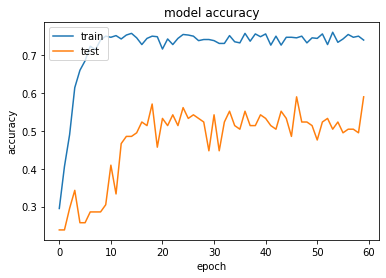

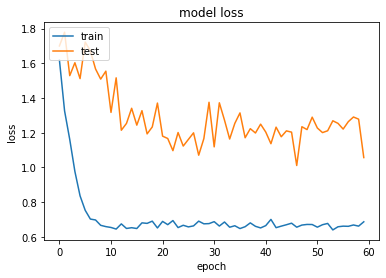

In [23]:
plotSummary(model_result)

In [27]:
from keras.optimizers import Adam
batch_size = 20
num_epochs = 60
x = 120
y = 120
image_index = np.arange(1,30,2) # Take alternative images
nb_filters = [8,16,32,64]
nb_dense = [256, 128, 5]

# Input
input_shape=(len(image_index),x,y,3)
#input_shape = np.zeros((batch_size,len(image_index),x,y,3))
#CNN2D + LSTM
model_c2d_lstm = Sequential()



model_c2d_lstm.add(TimeDistributed(Conv2D(16, (3, 3), strides=(2, 2),
    activation='relu', padding='same'), input_shape=input_shape))
model_c2d_lstm.add(TimeDistributed(BatchNormalization()))
model_c2d_lstm.add(TimeDistributed(Conv2D(16, (3,3),
    kernel_initializer="he_normal", activation='relu')))
model_c2d_lstm.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_c2d_lstm.add(TimeDistributed(Conv2D(32, (3,3),
    padding='same', activation='relu')))
model_c2d_lstm.add(TimeDistributed(BatchNormalization()))
model_c2d_lstm.add(TimeDistributed(Conv2D(32, (3,3),
    padding='same', activation='relu')))
model_c2d_lstm.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_c2d_lstm.add(TimeDistributed(Conv2D(64, (3,3),
    padding='same', activation='relu')))
model_c2d_lstm.add(TimeDistributed(BatchNormalization()))
model_c2d_lstm.add(TimeDistributed(Conv2D(64, (3,3),
    padding='same', activation='relu')))
model_c2d_lstm.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_c2d_lstm.add(TimeDistributed(Conv2D(128, (3,3),
    padding='same', activation='relu')))
model_c2d_lstm.add(TimeDistributed(BatchNormalization()))
model_c2d_lstm.add(TimeDistributed(Conv2D(128, (3,3),
    padding='same', activation='relu')))
model_c2d_lstm.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_c2d_lstm.add(TimeDistributed(Conv2D(256, (3,3),
    padding='same', activation='relu')))
model_c2d_lstm.add(TimeDistributed(BatchNormalization()))
model_c2d_lstm.add(TimeDistributed(Conv2D(256, (3,3),
    padding='same', activation='relu')))
model_c2d_lstm.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_c2d_lstm.add(TimeDistributed(Flatten()))

model_c2d_lstm.add(Dropout(0.5))
model_c2d_lstm.add(LSTM(128, return_sequences=False, dropout=0.5))
model_c2d_lstm.add(Dense(nb_dense[2], activation='softmax'))
# For CNN + LSTM
optimiser = Adam() #write your optimizer
model_c2d_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_c2d_lstm.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_49 (TimeDis (None, 15, 60, 60, 16)    448       
_________________________________________________________________
time_distributed_50 (TimeDis (None, 15, 60, 60, 16)    64        
_________________________________________________________________
time_distributed_51 (TimeDis (None, 15, 58, 58, 16)    2320      
_________________________________________________________________
time_distributed_52 (TimeDis (None, 15, 29, 29, 16)    0         
_________________________________________________________________
time_distributed_53 (TimeDis (None, 15, 29, 29, 32)    4640      
_________________________________________________________________
time_distributed_54 (TimeDis (None, 15, 29, 29, 32)    128       
_________________________________________________________________
time_distributed_55 (TimeDis (None, 15, 29, 29, 32)   

In [28]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [31]:
model_name = 'Conv2DLSTM_Final' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.20, patience=5, cooldown=1, verbose=1, mode='auto', min_delta=0.0001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [32]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [35]:
model_result=model_c2d_lstm.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Epoch 1/60
 1/34 [..............................] - ETA: 4s - loss: 1.4112 - categorical_accuracy: 0.3500

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


34/34 [==============================] - 41s 1s/step - loss: 1.3178 - categorical_accuracy: 0.3603 - val_loss: 3.0102 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to Conv2DLSTM_Final_2021-03-2806_41_45.931307/model-00001-1.31779-0.36029-3.01020-0.21000.h5
Epoch 2/60
34/34 [==============================] - 39s 1s/step - loss: 1.1698 - categorical_accuracy: 0.4353 - val_loss: 3.1966 - val_categorical_accuracy: 0.1800

Epoch 00002: saving model to Conv2DLSTM_Final_2021-03-2806_41_45.931307/model-00002-1.16980-0.43529-3.19664-0.18000.h5
Epoch 3/60
34/34 [==============================] - 40s 1s/step - loss: 1.0951 - categorical_accuracy: 0.5176 - val_loss: 3.4381 - val_categorical_accuracy: 0.1800

Epoch 00003: saving model to Conv2DLSTM_Final_2021-03-2806_41_45.931307/model-00003-1.09512-0.51765-3.43813-0.18000.h5
Epoch 4/60
34/34 [==============================] - 40s 1s/step - loss: 0.9660 - categorical_accuracy: 0.5706 - val_loss: 2.9592 - val_categorical_accuracy: 0.

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


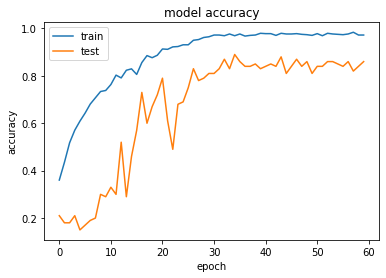

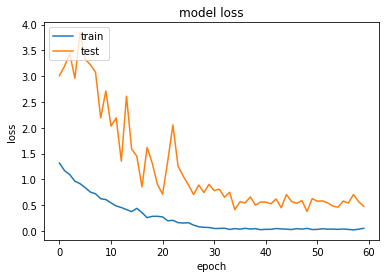

In [36]:
plotSummary(model_result)